In [1]:
# import library
import numpy as np
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [10]:
# identifying closet value in the lat long array
def nearest_point(location_array, location_of_interest):
    """
    This function search for the nearest lat from
    a netcdf lat array.
    input: netcdf lat array, lat in mind
    output: nearest  lat
    useage: in this way we can copy the data value nearest to our location
    from the raster, unless xarray raise errors
    """
    idx = np.abs(location_array - location_of_interest).argmin()
    return location_array[idx]

In [2]:
# read nc file
# file source
fn = './input/pr_2021.nc'
precep = xr.open_dataset(fn)
precep

<xarray.Dataset>
Dimensions:               (lon: 1386, lat: 585, day: 365, crs: 1)
Coordinates:
  * lon                   (lon) float64 -124.8 -124.7 -124.7 ... -67.1 -67.06
  * lat                   (lat) float64 49.4 49.36 49.32 ... 25.15 25.11 25.07
  * day                   (day) datetime64[ns] 2021-01-01 ... 2021-12-31
  * crs                   (crs) uint16 3
Data variables:
    precipitation_amount  (day, lat, lon) float32 ...
Attributes: (12/19)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    date:                       03 March 2022
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

In [3]:
# use rio.crs from rioxarray
crs_precep = precep.rio.crs
print(crs_precep)
#print first 5 values
x = precep["precipitation_amount"]["lat"].values[:5]
y = precep["precipitation_amount"]["lon"].values[500]
print('x is {} y is {}'.format(x,y))
# see max and min lat lon values
print('min lat is {} and max lat is {}'.format(precep["precipitation_amount"]["lat"].values.min(),
                                               precep["precipitation_amount"]["lat"].values.max()))
# see max and min lon values
print('min lon is {} and max lon is {}'.format(precep["precipitation_amount"]["lon"].values.min(),
                                              precep["precipitation_amount"]["lon"].values.max()))

EPSG:4326
x is [49.4        49.35833333 49.31666667 49.275      49.23333333] y is -103.93333330000002
min lat is 25.066666666666666 and max lat is 49.400000000000006
min lon is -124.76666663333334 and max lon is -67.05833330000002


In [4]:
# data range
print('date range for data is {} to {}'.format
      (precep["precipitation_amount"]["day"].values.min(),
      precep["precipitation_amount"]["day"].values.max()))

date range for data is 2021-01-01T00:00:00.000000000 to 2021-12-31T00:00:00.000000000


In [5]:
# see attribute data
metadata = precep.attrs
metadata['note2']

'Citation: Abatzoglou, J.T., 2013, Development of gridded surface meteorological data for ecological applications and modeling, International Journal of Climatology, DOI: 10.1002/joc.3413'

In [17]:
start_date = '2021-06-30'
end_date ='2021-09-01'
# point of interest
lat_of_interest = 33 # 40.367474
lon_of_interest = -90 #-82.996216
# use commenting properly
#loc = 400 
# alternatively define a single point using following lines
#lat = precep["precipitation_amount"]["lat"].values[loc]
#lon = precep["precipitation_amount"]["lon"].values[loc]

# nearest lat
lat = nearest_point(precep["precipitation_amount"]["lat"], lat_of_interest )
lon = nearest_point(precep["precipitation_amount"]["lon"], lon_of_interest )# print values for 400 postion
print('lat %d and lon %d' % (lat, lon)) 
# precipitation value
point_precep = precep["precipitation_amount"].sel(lat=lat,
                                                 lon=lon,
                                                 #day=slice(start_date,end_date)
                                                 )
point_precep

lat 32 and lon -90


<xarray.DataArray 'precipitation_amount' (day: 365)>
array([0. , 0. , 0. , ..., 7.6, 0.5, 0. ], dtype=float32)
Coordinates:
    lon      float64 -90.02
    lat      float64 32.98
  * day      (day) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-12-31
Attributes:
    units:              mm
    description:        Daily Accumulated Precipitation
    long_name:          pr
    standard_name:      pr
    dimensions:         lon lat time
    grid_mapping:       crs
    coordinate_system:  WGS84,EPSG:4326
    coordinates:        lon lat time

[netcdf tutorial](https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/use-netcdf-in-python-xarray/)

[slice using shape](https://www.earthdatascience.org/courses/use-data-open-source-python/hierarchical-data-formats-hdf/subset-netcdf4-climate-data-spatially-aoi/)

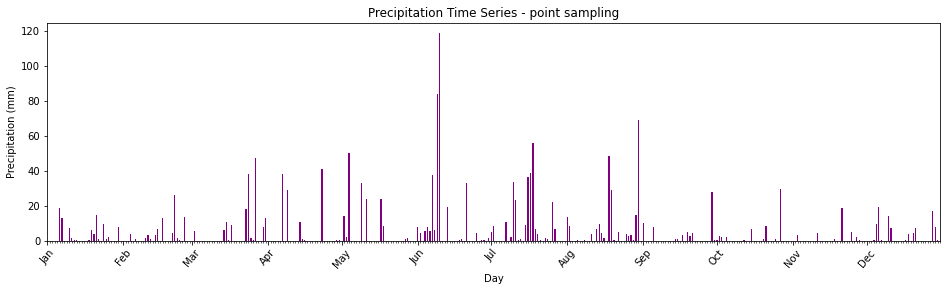

In [18]:
# create barplot for showling data
# bar data
precepitation = point_precep
# time data
time = precepitation["day"]
# uncomment for year around data
#time = precep["precipitation_amount"]["day"]
# create figure object
fig, (ax1)= plt.subplots(figsize=(16,4))
#ploting bars
ax1.bar(time,precepitation,
       color='purple',
       width=0.5)
ax1.set(title='Precipitation Time Series - point sampling')
plt.xlabel('Day')
plt.ylabel('Precipitation (mm)')
# month location
months = mdates.MonthLocator()
# days location
days = mdates.DayLocator()
# months format when display
monthFmt = mdates.DateFormatter('%b')
# set locators to axis
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_minor_locator(days)
# set display day formatter to axis
ax1.xaxis.set_major_formatter(monthFmt)
# set x axis limits
ax1.set_xlim(time.min(), time.max())
# x tick rotation
plt.xticks(rotation=50)
plt.show()

In [19]:
# cast netcdf data into a dataframe
precep_df = precepitation.to_dataframe()
precep_df
# Save file if needed

,lon,lat,precipitation_amount
day,,,
2021-01-01,-90.016667,32.983333,0.000000
2021-01-02,-90.016667,32.983333,0.000000
2021-01-03,-90.016667,32.983333,0.000000
2021-01-04,-90.016667,32.983333,0.000000
2021-01-05,-90.016667,32.983333,0.000000
...,...,...,...
2021-12-27,-90.016667,32.983333,0.000000
2021-12-28,-90.016667,32.983333,17.200001
2021-12-29,-90.016667,32.983333,7.600000
